In [1]:
#
# This notebook is written in a way intended to be view
# with cell inputs hidden. If this comment is visible,
# the data is at the end of the report, you may just ignore
# all the code.
#
# intended usage: convert to html with cell execution enabled
# > jupyter nbconvert --to=html --no-input --ExecutePreprocessor.enabled=True TM-status-report.ipynb
#
# if working in the gis repository, run:
# > make
# to automatically run, convert, and publish of github pages


# Tasking Manager COVID-19 Projects Summary


This is a Jupyter notebook for quickly summarizing the status of a HOTOSM Tasking Manager campaing using the TM API.
Data show here is periodically updated by and automated bot.


In [2]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from IPython.core.display import display, HTML
# make sure pandas doesn't truncate the dataframe when rendered
pd.set_option('display.max_rows', 500)

import tasking_manager_client as tm

            
# set the text search keyword
textSearch = 'covid'
projectStatuses = 'ARCHIVED,PUBLISHED,DRAFT'
instance = 'tasks.hotosm.org'

# for notebooks used for reporting, it's nice to
# timestamp of the data, since it can get old quickly
now = datetime.utcnow()
print(f'data last updated: {now} UTC')
print(f'tasking manager:   {instance}')
print(f'search keyword:    {textSearch}')

data last updated: 2020-05-06 16:22:51.030128 UTC
tasking manager:   tasks.hotosm.org
search keyword:    covid


In [3]:

# concatenate paginated API results into one dataframe
result = pd.concat(tm.v2.project_search(textSearch=textSearch, projectStatuses=projectStatuses), ignore_index=True);
# search API pagination sometimes returns the same project more than once
result = result.drop_duplicates(subset='projectId');


In [4]:
result.count()

projectId            126
locale               126
name                 126
shortDescription     126
mapperLevel          126
priority             126
organisationName     126
organisationLogo      22
campaign               0
percentMapped        126
percentValidated     126
status               126
activeMappers        126
lastUpdated          126
dueDate                0
totalContributors    126
country              126
page                 126
dtype: int64

In [5]:
result.head()

,projectId,locale,name,shortDescription,mapperLevel,priority,organisationName,organisationLogo,campaign,percentMapped,percentValidated,status,activeMappers,lastUpdated,dueDate,totalContributors,country,page
0,8467,en,"COVID-19 - Pampamarca, Cusco, Peru",English\n\nHOT is mapping Cusco region in Peru...,BEGINNER,URGENT,Gal School Peru,None,None,17,0,PUBLISHED,8,2020-05-06T16:16:00.844494Z,None,17,[Peru],1
1,8188,es,Mapatón COVID-19 Medellín - Comuna 1,"Con el avance del virus COVID-19 en Colombia, ...",BEGINNER,URGENT,GeolabUdea,None,None,99,46,PUBLISHED,2,2020-05-06T05:12:55.161240Z,None,551,[Colombia],1
2,8453,en,"COVID-19 - Tenta, Cusco, Peru",HOT is mapping Cusco region in Peru at the req...,BEGINNER,URGENT,Gal School Peru,None,None,96,36,PUBLISHED,1,2020-05-06T16:16:23.657339Z,None,114,[Peru],1
3,8469,en,"COVID-19 - Gao - Gao, Mali",`Help Validate - Go to bit.ly/HOTValidators to...,INTERMEDIATE,URGENT,HOT,https://cdn.hotosm.org/tasking-manager/uploads...,None,99,56,PUBLISHED,2,2020-05-06T16:20:21.612794Z,None,327,[Mali],1
4,8596,en,"COVID-19 - Camanti, Cusco, Peru",HOT is mapping Cusco region in Peru at the req...,BEGINNER,URGENT,Gal School Peru,None,None,0,0,DRAFT,0,2020-05-05T14:16:09.944023Z,None,0,[Peru],1


In [6]:
def get_summaries():
  for idx, project in result.iterrows():


    endpoint = f'/api/v2/projects/{project.projectId}/statistics/'
    r = requests.get('https://' + tm.DEFAULT_INSTANCE_API + endpoint)
    df = pd.json_normalize(r.json())
    yield df

summaries = pd.concat(get_summaries())
# summaries

In [7]:
cols_to_use = summaries.columns.difference(result.columns)
result = result.merge(summaries, suffixes=('', '_duplicate'), how='outer')
result.drop(result.filter(regex='_duplicate$').columns.tolist(),axis=1, inplace=True)
result.columns

Index(['projectId', 'locale', 'name', 'shortDescription', 'mapperLevel',
       'priority', 'organisationName', 'organisationLogo', 'campaign',
       'percentMapped', 'percentValidated', 'status', 'activeMappers',
       'lastUpdated', 'dueDate', 'totalContributors', 'country', 'page',
       'projectArea(in sq.km)', 'totalMappers', 'totalTasks', 'totalComments',
       'totalMappingTime', 'totalValidationTime', 'totalTimeSpent',
       'averageMappingTime', 'averageValidationTime', 'percentBadImagery',
       'aoiCentroid.type', 'aoiCentroid.coordinates'],
      dtype='object')

## Current Published and Archived Projects

Published projects: 89
Archived projects:  15
Total projects:     126


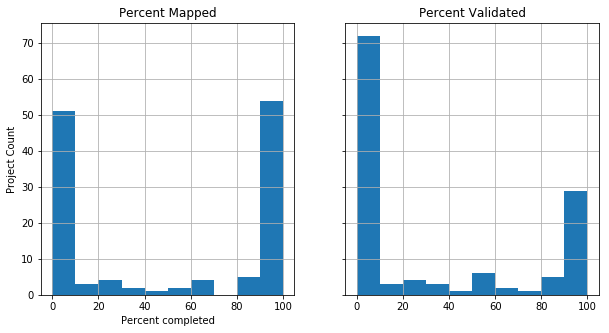

In [8]:

# Total count of projects
print('Published projects:', len(result[result.status == 'PUBLISHED']))
print('Archived projects: ', len(result[result.status == 'ARCHIVED']))
print('Total projects:    ', len(result))

fig, axs = plt.subplots(1,2, sharey=True, figsize=(10,5))
ax = axs[0]
ax.set_ylabel('Project Count')
ax.set_xlabel('Percent completed')
ax.hist(result.percentMapped)
ax.set_title('Percent Mapped')
ax.grid()
ax = axs[1]
ax.grid()
ax.set_title('Percent Validated')
ax.hist(result.percentValidated)
plt.show()



The table below shows the current status of all published and archived projects that include the `covid` keyword.

Projects are sorted by project id, meaning they are in somewhat choronological order.

You can click the project Id to open it in TM.

In [17]:
# We select only the most interesting fields from the dataframe

result['projectArea(in sq.km)'] = result['projectArea(in sq.km)'].apply(int)
result['country'] = result['country'].apply(lambda val: val[0] if isinstance(val, list) else val)

sorted_vals = result.sort_values('projectId')
sorted_vals['hyperlink'] = sorted_vals['projectId'].apply(tm.style.format_project_link)
del sorted_vals['shortDescription']
del sorted_vals['aoiCentroid.type']
del sorted_vals['page']
del sorted_vals['organisationLogo']
sorted_vals.to_csv('TM-status-report.csv', index=False)
del sorted_vals['hyperlink']



# apply custom styler functions to final table
styled = sorted_vals.style\
    .background_gradient(cmap=tm.style.hotosm_cmap(),subset=['percentMapped', 'percentValidated'])\
    .applymap(tm.style.format_priority, subset=['priority'])\
    .applymap(tm.style.format_status, subset=['status'])\
    .format({'projectId': tm.style.format_clickable_project_id})


display(styled)

26


,projectId,locale,name,mapperLevel,priority,organisationName,campaign,percentMapped,percentValidated,status,activeMappers,lastUpdated,dueDate,totalContributors,country,projectArea(in sq.km),totalMappers,totalTasks,totalComments,totalMappingTime,totalValidationTime,totalTimeSpent,averageMappingTime,averageValidationTime,percentBadImagery,aoiCentroid.coordinates
53,813,fr,Mali - [Projets de Cartographie systématique - réseau routier principal vs référence open data],INTERMEDIATE,LOW,OSM Mali,None,9,0,ARCHIVED,0,2020-04-29T12:23:42.789643Z,None,69,Mali,160304,23,2592,1,1329631.000000,5364.000000,1334995.000000,22924.672414,1788.000000,0,"[-5.6053668704533, 14.8214902416722]"
33,5909,en,"COVID-19, Quehue, Anna, Cusco Peru",BEGINNER,LOW,Gal School Peru,None,100,100,PUBLISHED,0,2020-05-01T19:36:22.859376Z,None,42,Peru,148,20,146,0,351284.000000,143242.000000,494526.000000,14051.360000,17905.250000,0,"[-71.4895060245859, -14.3656907940811]"
110,7372,en,"COVID-19 - Paucartambo 1, Cusco, Peru",BEGINNER,LOW,Gal School Peru,None,98,51,PUBLISHED,0,2020-05-05T18:15:19.361643Z,None,841,Peru,2656,429,2525,2,8778614.000000,703813.000000,9482427.000000,13402.464122,24269.413793,0,"[-71.6165475171894, -13.2871048929094]"
111,7379,en,"COVID-19 Yaurisque District, Cusco - Peru",BEGINNER,LOW,Gal School Peru,None,100,100,ARCHIVED,0,2020-04-07T11:52:00.895374Z,None,50,Peru,100,22,154,1,380598.000000,53803.000000,434401.000000,11893.687500,26901.500000,0,"[-71.9125913308375, -13.6509183364594]"
112,7719,en,"COVID-19 - Chinchero - Urubamba, Peru",BEGINNER,LOW,Gal School Peru,None,100,100,ARCHIVED,0,2020-03-27T10:41:53.477054Z,None,192,Peru,102,91,173,0,1237320.000000,232124.000000,1469444.000000,8533.241379,25791.555556,0,"[-72.0387779231764, -13.4093831008486]"
60,7720,en,"COVID-19 - Yucay, Cusco, Peru",BEGINNER,LOW,Gal School Peru,None,100,100,ARCHIVED,0,2020-04-01T10:32:56.854068Z,None,36,Peru,23,24,63,3,142965.000000,109716.000000,252681.000000,6807.857143,9974.181818,0,"[-72.0732270737177, -13.2942402087115]"
52,7721,en,"COVID-19 - Coya - Calca, Peru",BEGINNER,LOW,Gal School Peru,None,100,100,ARCHIVED,0,2020-04-21T14:36:00.118975Z,None,66,Peru,70,44,110,0,178416.000000,273592.000000,452008.000000,3186.000000,54718.400000,0,"[-71.9153272241254, -13.402415786215]"
36,7768,en,"COVID-19 - Chamaca - Chumbivilcas, Peru",BEGINNER,LOW,Gal School Peru,None,100,100,PUBLISHED,0,2020-04-28T06:04:23.797669Z,None,153,Peru,674,64,593,1,963039.000000,1164237.000000,2127276.000000,8835.220183,129359.666667,0,"[-71.8769132207194, -14.3344207276267]"
32,7769,en,"COVID-19 - Saylla - Cusco , Peru",BEGINNER,LOW,Gal School Peru,None,100,100,ARCHIVED,0,2020-04-13T06:20:16.409879Z,None,51,Peru,24,24,64,2,278995.000000,63629.000000,342624.000000,7971.285714,21209.666667,0,"[-71.8317557542491, -13.5530044401982]"
29,7770,en,"COVID-19 San Jeronimo - Cusco , Peru",BEGINNER,LOW,Gal School Peru,None,92,91,PUBLISHED,0,2020-05-04T01:08:29.782119Z,None,237,Peru,95,105,248,1,1250372.000000,416420.000000,1666792.000000,7766.285714,17350.833333,0,"[-71.867424244068, -13.5574108920958]"


Notebook maintained by @jarmokivekas (GitHub & HOTOSM Slack), feedback and development ideas welcome.